In [1]:
import numpy as np
import pandas as pd
from constants import *
import matplotlib.pyplot as plt

sb_data_file = 'D:/UVic/CSC503Proj/data/merged_data.csv'
sb_filtered_data_file = 'D:/UVic/CSC503Proj/data/filtered_data.csv'

unwanted_cols__ = ['Unnamed: 0', 'videoID', 'UUID', 'description', 'title', 'userID', 'channelID', 'incorrectVotes']

In [2]:
# Read the file, filter the columns, and save the new file


# df = pd.read_csv(sb_data_file, low_memory=False)
# filtered_df = df.loc[:, ~df.columns.isin(unwanted_cols__)]
# filtered_df.to_csv(sb_filtered_data_file, index=False)

# print(f"Filtered data has been written to {sb_filtered_data_file}")

In [3]:
sb_data = pd.read_csv(sb_filtered_data_file, 
                      dtype=dtypes,
                      usecols=lambda col: col not in unwanted_cols__,
                      #converters={'timeSubmitted':convert_timestamp_to_seconds},
                      # skiprows=range(1, 6_000_000),
                      # nrows = 8_000_000,
                      na_values={'videoDuration': [0],
                                 'published': [0]})

pd.set_option('display.max_columns', None)
display(sb_data.head())

,startTime,endTime,votes,locked,timeSubmitted,views,category,actionType,videoDuration,hidden,reputation,shadowHidden,published,isVIP
0,714.00000,763.00000,64,False,1.564089e+09,386,sponsor,skip,NaN,0,0.0,False,1.529539e+09,False
1,446.51013,513.39233,225,False,1.564089e+09,3222,sponsor,skip,NaN,1,0.0,False,1.562458e+09,False
2,488.52150,542.11035,-2,False,1.564089e+09,25661,sponsor,skip,552.0,0,0.0,False,1.534032e+09,False
3,497.14310,569.15330,-2,False,1.564089e+09,24217,sponsor,skip,NaN,0,0.0,False,1.517443e+09,False
4,41.00000,53.00000,115,False,1.564089e+09,768,sponsor,skip,NaN,0,0.0,False,1.529539e+09,False


In [4]:
# readCol = ['category']
# sb_data_cat = pd.read_csv(sb_filtered_data_file, 
#                       dtype=dtypes,
#                       usecols=lambda col: col in readCol)
# print(len(sb_data_cat))
# sb_data_cat['category'].value_counts()
# print(len(sb_data_cat))

In [5]:
print(len(sb_data))
sb_data['category'].value_counts()
sb_data = sb_data[sb_data['category'] != 'moreCategories']
print(len(sb_data))

15334922
15334918


In [6]:
# sb_data['category'].remove_unused_categories()
sb_data["category"].cat.remove_categories(['moreCategories'])
sb_data['category'].value_counts()

category
sponsor             3483201
intro               2742959
filler              2676918
outro               2107166
selfpromo           1339473
interaction         1177598
poi_highlight        771380
preview              421595
music_offtopic       404021
chapter              190634
exclusive_access      19973
moreCategories            0
Name: count, dtype: int64

In [7]:
# fraction = 0.2
# stratified_sample = sb_data.groupby('category', group_keys=False).apply(lambda x: x.sample(frac=fraction))
# stratified_sample.reset_index(drop=True, inplace=True)

stratified_sample = sb_data

In [8]:
print(len(stratified_sample))

15334918


In [9]:
stratified_sample['category'].value_counts()

category
sponsor             3483201
intro               2742959
filler              2676918
outro               2107166
selfpromo           1339473
interaction         1177598
poi_highlight        771380
preview              421595
music_offtopic       404021
chapter              190634
exclusive_access      19973
moreCategories            0
Name: count, dtype: int64

In [10]:
# stratified_sample['segmentDuration'] = stratified_sample['endTime']-stratified_sample['startTime']
# stratified_sample['scaledStart'] = stratified_sample['startTime']/stratified_sample['videoDuration']
# stratified_sample['scaledEnd'] = stratified_sample['endTime']/stratified_sample['videoDuration']
# stratified_sample['scaledSegmentDuration'] = stratified_sample['segmentDuration']/stratified_sample['videoDuration']
# stratified_sample['timeToSubmission'] = stratified_sample['timeSubmitted']-stratified_sample['published']

In [11]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

In [12]:
train_set, test_set = train_test_split(stratified_sample, test_size=0.2, random_state=42, stratify=stratified_sample["category"])
len(train_set), len(test_set)


sb = train_set.drop("category", axis=1)
sb_labels = train_set["category"].copy()
sb_test = test_set.drop("category", axis=1)


sb_labels_test = test_set["category"].copy()

# sb.head()
sb_labels.value_counts()


category
sponsor             2786561
intro               2194367
filler              2141534
outro               1685733
selfpromo           1071578
interaction          942078
poi_highlight        617104
preview              337276
music_offtopic       323217
chapter              152507
exclusive_access      15979
moreCategories            0
Name: count, dtype: int64

In [13]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"),
                            StandardScaler())

cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"),
                                        OneHotEncoder(handle_unknown='ignore'))

actiontype_pipeline = make_pipeline(OneHotEncoder(handle_unknown='ignore'))

num_attribs = ['startTime', 'endTime', 'votes', 'timeSubmitted', 'views', 'videoDuration', 'reputation', 'published']
cat_attribs = ['locked', 'hidden', 'shadowHidden', 'isVIP']


# num_attribs = ['startTime', 'endTime', 'votes', 'timeSubmitted', 'views', 'video duration', 'reputation', 'published']
# cat_attribs = ['locked', 'actionType', 'hidden', 'shadowHidden', 'isVIP']


preprocess_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs), 
                                         ('cat', cat_pipeline, cat_attribs),
                                         ('action', actiontype_pipeline, ['actionType'])
                                        ])

# preprocess_pipeline = ColumnTransformer([('num', num_pipeline, num_attribs)])


# sb_processed = preprocess_pipeline.fit_transform(sb)
# print(sb_processed[:5])

# sb_processed = pd.DataFrame(sb_processed,
# columns=preprocess_pipeline.get_feature_names_out())
# sb_processed.head()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import classification_report, accuracy_score

# Preprocessing the data
sb_processed = preprocess_pipeline.fit_transform(sb)
sb_test_processed = preprocess_pipeline.transform(sb_test)

print(sb_processed.shape)

(12267934, 22)


In [15]:
sb_labels = sb_labels.to_frame()
sb_labels_test = sb_labels_test.to_frame()

sb_labels.head()

,category
4071129,intro
1797132,sponsor
14084936,intro
11542449,intro
10378451,outro


In [16]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
# from sklearn.preprocessing import LabelEncoder
# from sklearn.metrics import classification_report, accuracy_score

# # Check for GPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Convert labels to numeric values using LabelEncoder
# label_encoder = LabelEncoder()
# sb_labels_encoded = label_encoder.fit_transform(sb_labels)  # Train labels
# sb_labels_test_encoded = label_encoder.transform(sb_labels_test)  # Test labels

# # Convert to PyTorch tensors and move to device
# X_train = torch.tensor(sb_processed, dtype=torch.float32).to(device)  # Feature data
# y_train = torch.tensor(sb_labels_encoded, dtype=torch.long).to(device)  # Encoded labels
# X_test = torch.tensor(sb_test_processed, dtype=torch.float32).to(device)
# y_test = torch.tensor(sb_labels_test_encoded, dtype=torch.long).to(device)

# # Create DataLoader for training
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# # Define the Neural Network Model
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, num_classes):
#         super(NeuralNetwork, self).__init__()
#         self.network = nn.Sequential(
#             nn.Linear(input_size, 128),
#             nn.ReLU(),
#             nn.BatchNorm1d(128),
#             nn.Dropout(0.3),
#             nn.Linear(128, 64),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(64, num_classes)
#         )

#     def forward(self, x):
#         return self.network(x)

# # Initialize the model, loss function, and optimizer, and move the model to the device
# input_size = X_train.shape[1]
# num_classes = len(label_encoder.classes_)  # Number of unique classes
# model = NeuralNetwork(input_size, num_classes).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Training the model
# epochs = 5
# model.train()
# for epoch in range(epochs):
#     running_loss = 0.0
#     for inputs, labels in train_loader:
#         # Move inputs and labels to device
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()

#     print(f"Epoch {epoch + 1}/{epochs}, Loss: {running_loss / len(train_loader)}")

# # Evaluate the model
# model.eval()
# with torch.no_grad():
#     outputs = model(X_test)
#     _, predicted_classes = torch.max(outputs, 1)
#     true_classes = y_test

# # Move predictions and true classes to CPU for evaluation
# predicted_classes = predicted_classes.cpu()
# true_classes = true_classes.cpu()

# # Classification report
# print("Classification Report:")
# print(classification_report(true_classes.numpy(), predicted_classes.numpy(), target_names=label_encoder.classes_))

# # Accuracy score
# print(f"Accuracy Score: {accuracy_score(true_classes.numpy(), predicted_classes.numpy())}")


In [17]:
# from sklearn.preprocessing import LabelEncoder
# from sklearn.dummy import DummyClassifier
# from sklearn.metrics import classification_report, accuracy_score

# label_encoder = LabelEncoder()
# sb_labels_encoded = label_encoder.fit_transform(sb_labels)  # Train labels
# sb_labels_test_encoded = label_encoder.transform(sb_labels_test)  # Test labels

# # Dummy Classifier for Baseline
# # Initialize the Dummy Classifier with "most_frequent" strategy
# dummy_clf = DummyClassifier(strategy="stratified")

# # Fit the Dummy Classifier using the same training labels
# dummy_clf.fit(sb_processed, sb_labels_encoded)

# # Generate predictions for the test set
# dummy_predictions = dummy_clf.predict(sb_test_processed)

# # Evaluate the Dummy Classifier
# dummy_accuracy = accuracy_score(sb_labels_test_encoded, dummy_predictions)
# print(f"Dummy Classifier Accuracy: {dummy_accuracy:.4f}")

# # Detailed Classification Report for the Dummy Classifier
# print("Dummy Classifier Classification Report:")
# print(classification_report(sb_labels_test_encoded, dummy_predictions, target_names=label_encoder.classes_))

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Encode the labels
label_encoder = LabelEncoder()
sb_labels_encoded = label_encoder.fit_transform(sb_labels)  # Train labels
sb_labels_test_encoded = label_encoder.transform(sb_labels_test)  # Test labels

# Define dummy classifier strategies
strategies = ["most_frequent", "stratified", "uniform", "constant", "prior"]
results = []

# Iterate through strategies
for strategy in strategies:
    if strategy == "constant":
        # DummyClassifier with constant strategy needs a specific constant value
        dummy_clf = DummyClassifier(strategy="constant", constant=0)
    else:
        dummy_clf = DummyClassifier(strategy=strategy)
    
    # Fit the Dummy Classifier using the same training labels
    dummy_clf.fit(sb_processed, sb_labels_encoded)

    # Generate predictions for the test set
    dummy_predictions = dummy_clf.predict(sb_test_processed)

    # Evaluate the Dummy Classifier
    dummy_accuracy = accuracy_score(sb_labels_test_encoded, dummy_predictions)
    
    # Append results
    results.append({"Strategy": strategy, "Accuracy (%)": dummy_accuracy * 100})

# Convert results to a DataFrame for display
results_df = pd.DataFrame(results)
print(results_df)

# Display the table
# import ace_tools as tools; tools.display_dataframe_to_user(name="Dummy Classifier Accuracies", dataframe=results_df)


C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


        Strategy  Accuracy (%)
0  most_frequent     22.714171
1     stratified     15.028706
2        uniform      9.112274
3       constant      1.243143
4          prior     22.714171


In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Convert labels to numeric values using LabelEncoder
label_encoder = LabelEncoder()
sb_labels_encoded = label_encoder.fit_transform(sb_labels)  # Train labels
sb_labels_test_encoded = label_encoder.transform(sb_labels_test)  # Test labels

# Decision trees do not require GPU; convert data to NumPy arrays
X_train = sb_processed  # Already processed feature data
y_train = sb_labels_encoded  # Encoded train labels
X_test = sb_test_processed
y_test = sb_labels_test_encoded  # Encoded test labels

# Initialize the Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(criterion="gini", max_depth=None, random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Make predictions on train data
y_train_pred = dt_classifier.predict(X_train)

# Make predictions on test data
y_test_pred = dt_classifier.predict(X_test)

# Evaluate the model on training data
# train_accuracy = accuracy_score(y_train, y_train_pred)
# print(f"Decision Tree Classifier Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Decision Tree Classifier Test Accuracy: {test_accuracy:.4f}")

# Classification report for test data
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Decision Tree Classifier Test Accuracy: 0.6266

Classification Report:
                  precision    recall  f1-score   support

         chapter       1.00      0.99      0.99     38127
exclusive_access       0.32      0.32      0.32      3994
          filler       0.86      0.87      0.86    535384
     interaction       0.30      0.30      0.30    235520
           intro       0.62      0.61      0.62    548592
  music_offtopic       0.33      0.34      0.34     80804
           outro       0.71      0.70      0.70    421433
   poi_highlight       1.00      1.00      1.00    154276
         preview       0.28      0.28      0.28     84319
       selfpromo       0.25      0.26      0.25    267895
         sponsor       0.64      0.64      0.64    696640

        accuracy                           0.63   3066984
       macro avg       0.57      0.57      0.57   3066984
    weighted avg       0.63      0.63      0.63   3066984



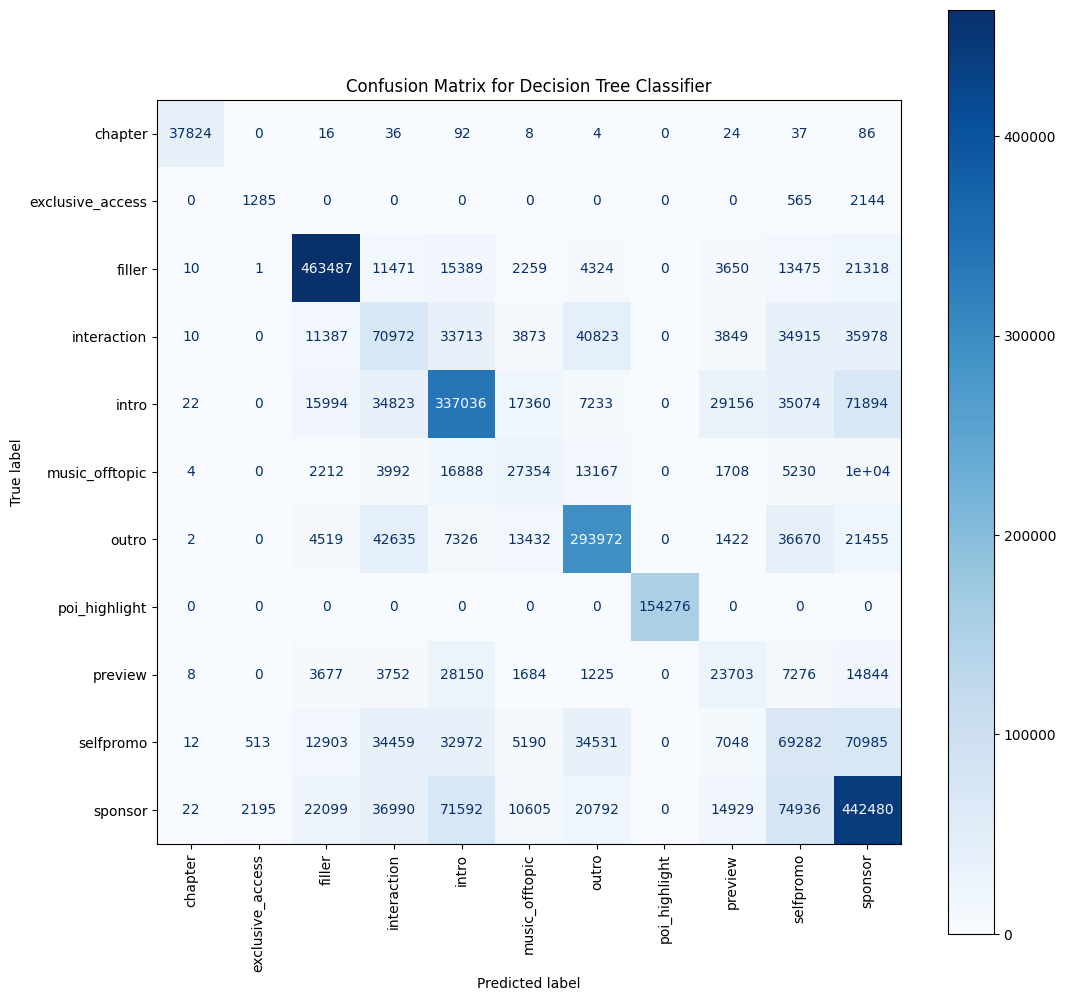

In [20]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix with increased figure size
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust figure size for better readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.title("Confusion Matrix for Decision Tree Classifier")
plt.show()


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

# Encode the labels to numeric values
label_encoder = LabelEncoder()
sb_labels_encoded = label_encoder.fit_transform(sb_labels)  # Train labels
sb_labels_test_encoded = label_encoder.transform(sb_labels_test)  # Test labels

# Use the processed features and encoded labels
X_train = sb_processed  # Preprocessed training features
y_train = sb_labels_encoded  # Encoded training labels
X_test = sb_test_processed  # Preprocessed test features
y_test = sb_labels_test_encoded  # Encoded test labels

# Initialize the Random Forest Classifier
rf_classifier = RandomForestClassifier(
    n_estimators=10,           # Number of trees in the forest
    max_depth=None,             # Allow the trees to grow fully
    random_state=42,            # Ensures reproducibility
    class_weight="balanced",    # Handle imbalanced classes
    n_jobs=-1                   # Use all available cores for faster computation
)

# Train the model
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_test_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred)
print(f"Random Forest Classifier Test Accuracy: {accuracy:.4f}")

# Classification report for detailed metrics
print("Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))


C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\joyji\.conda\envs\jupyter_env\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Random Forest Classifier Test Accuracy: 0.6884
Classification Report:
                  precision    recall  f1-score   support

         chapter       1.00      1.00      1.00     38127
exclusive_access       0.38      0.28      0.32      3994
          filler       0.91      0.88      0.90    535384
     interaction       0.37      0.29      0.32    235520
           intro       0.64      0.76      0.69    548592
  music_offtopic       0.48      0.35      0.41     80804
           outro       0.67      0.84      0.74    421433
   poi_highlight       1.00      1.00      1.00    154276
         preview       0.45      0.27      0.34     84319
       selfpromo       0.37      0.20      0.26    267895
         sponsor       0.69      0.72      0.71    696640

        accuracy                           0.69   3066984
       macro avg       0.63      0.60      0.61   3066984
    weighted avg       0.67      0.69      0.67   3066984



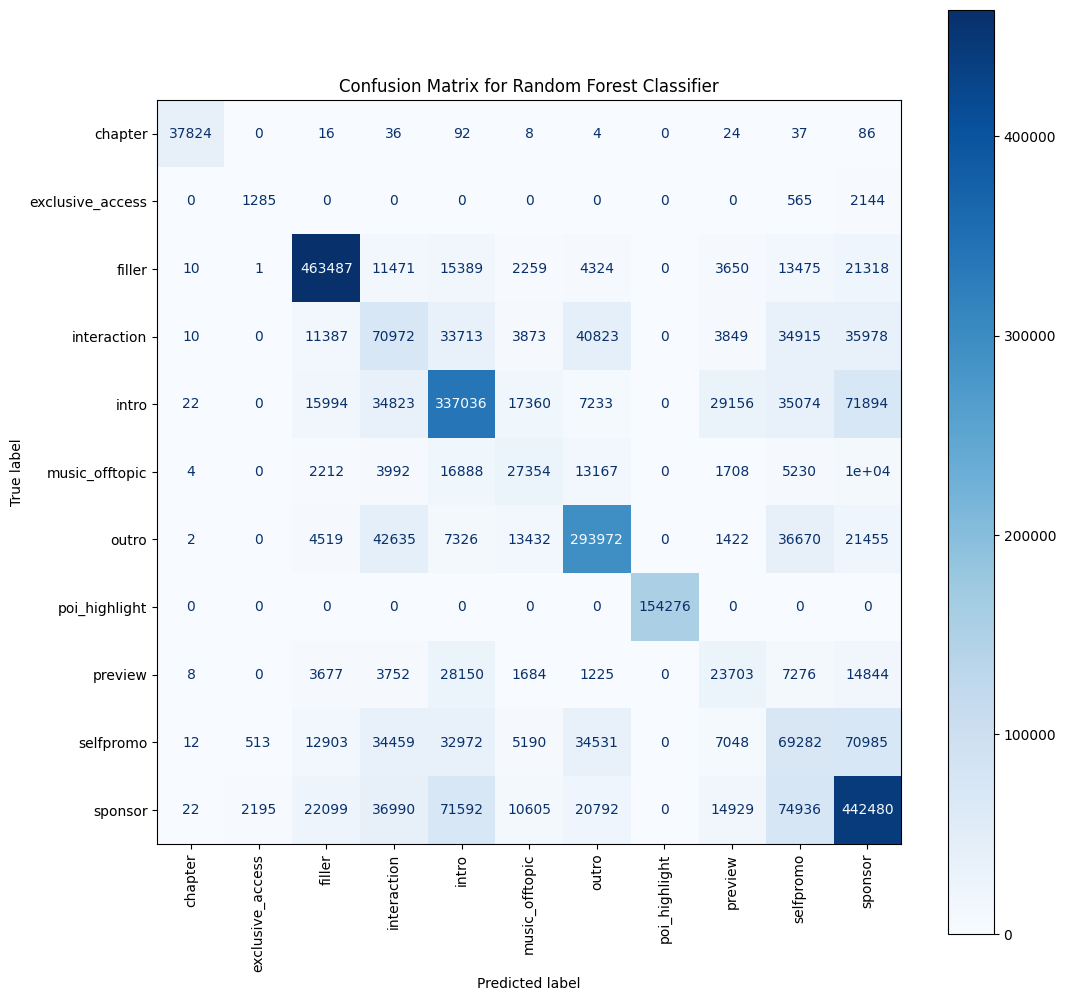

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Compute the confusion matrix
cm_ = confusion_matrix(y_test, y_test_pred)

# Display the confusion matrix with increased figure size
fig, ax = plt.subplots(figsize=(12, 12))  # Adjust figure size for better readability
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical', ax=ax)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()


In [23]:
# import matplotlib.pyplot as plt
# feature_importances = rf_classifier.feature_importances_
# plt.barh(range(len(feature_importances)), feature_importances)
# plt.show()
# print(feature_importances)

In [24]:
# !pip install tabulate

In [25]:
# from tabulate import tabulate

# # Data
# data = [
#     {"Strategy": "most_frequent", "Accuracy (%)": 22.766985},
#     {"Strategy": "stratified", "Accuracy (%)": 15.165871},
#     {"Strategy": "uniform", "Accuracy (%)": 9.078134},
# ]

# # Sort the data by Accuracy (%) in descending order
# sorted_data = sorted(data, key=lambda x: x["Accuracy (%)"], reverse=True)

# # Format data for tabulate
# table_data = [[row["Strategy"], f"{row['Accuracy (%)']:.2f}"] for row in sorted_data]

# # Create and display the table
# table = tabulate(table_data, headers=["Strategy", "Accuracy (%)"], tablefmt="grid")
# print(table)
